In [6]:
import os
import glob
from pathlib import Path

import requests
import difflib
import random


import json
import csv
import numpy as np
import pandas as pd 
import sklearn as sk 
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib notebook
import mplcursors
from ipywidgets import widgets
from ipywidgets import GridspecLayout
from ipywidgets import interactive
from ipywidgets import interact

from IPython.display import clear_output

In [7]:
#get data 
os.getcwd()
os.listdir('./transformed-data/')

filepath = "./transformed-data/aggdf.csv"
df = pd.read_csv(filepath)
print(df.columns)

Index(['player', 'aces', 'bk_pts', 'bp_saved', 'crosscourt', 'deep', 'dfs',
       'down_middle', 'down_the_line', 'err_deep', 'err_net', 'err_wide',
       'err_wide_deep', 'first_aces', 'first_forced', 'first_in', 'first_pts',
       'first_pts_won', 'first_unret', 'first_won', 'first_won_lte_3_shots',
       'forced_err', 'in_play', 'in_play_won', 'induced_forced', 'inside_in',
       'inside_out', 'net_pts', 'net_unforced', 'net_winner', 'passed_at_net',
       'passing_shot_induced_forced', 'pt_ending', 'pts', 'pts_won',
       'pts_won_lte_3_shots', 'return_forced', 'return_pts', 'return_pts_won',
       'returnable', 'returnable_won', 'second_aces', 'second_forced',
       'second_in', 'second_pts', 'second_pts_won', 'second_unret',
       'second_won', 'second_won_lte_3_shots', 'serve_pts', 'serve_return',
       'shallow', 'shots', 'shots_in_pts_lost', 'shots_in_pts_won', 'snv_pts',
       'total_shots', 'unforced', 'unforced_bh', 'unforced_fh', 'unret',
       'very_deep', 'w

In [8]:
# split player labels and attributes
X = df.loc[:, df.columns != 'player']
labels = df['player']

# params for cluster
eps = 0.025
min_samples= 5

In [31]:
class State_Component:
    def __init__(self,data,labels):
        self.data = data
        self.transformed_data = data.to_numpy()
        self.clusterlabels = [0]*len(data)#data.columns[1:-1].to_numpy()
        self.labels = labels
        #self.fig,self.ax = plt.subplots()
        self.options = X.columns[1:-1]
        
        # make menu widgets
        self.text = widgets.Text()
        self.button = widgets.Button(
                        description='Confirm',
                        disabled=False,
                        button_style='', # 'success', 'info', 'warning', 'danger' or ''
                        tooltip='Click me',
                        icon='check' # (FontAwesome names without the `fa-` prefix)
                    )
        
        
        self.multi_checkbox_widget()
        
        #widget events
        self.text.on_submit(self.handle_text_submit)
        self.button.on_click(self.handle_button_event)
        
        #draw grid
        self.grid()
        
        #draw plot
        self.norm = plt.Normalize(1,4)
        self.cmap = plt.cm.Spectral

        self.fig,self.ax = plt.subplots()
        self.callback = self.fig.canvas.mpl_connect("motion_notify_event", self.hover)
        
        self.sc = self.ax.scatter([0],[0],c=[0], s=100, cmap=cmap, norm=norm)
        self.annot = self.ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                            bbox=dict(boxstyle="round", fc="w"),
                            arrowprops=dict(arrowstyle="->"))
        self.annot.set_visible(False)
        self.fig.set_size_inches(9,8)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('PCA test for reduction to 2 components')
        
        
        
    def handle_button_event(self,sender):
        selected_options = [w.description for w in self.multi_select.children[1].children if w.value]
        if(len(selected_options) == 0):
            selected_options = [w.description for w in self.multi_select.children[1].children] # use everything if empty
        self.X = df[selected_options]
        x = df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(X)
        self.X_scaled = pd.DataFrame(x_scaled)

        #cluster
        self.cluster()
        
        #dbscan = DBSCAN(eps=eps,min_samples=min_samples)
        #clusterlabels = dbscan.fit_predict(X_scaled)


        #dimension reduction
        self.reduce()
#         pca = sk.decomposition.PCA(n_components = 2)
#         pca.fit(X)
#         self.data = pca.transform(X)

        #split data
        x = self.transformed_data[:,0]
        y = self.transformed_data[:,1]
        c = self.clusterlabels
        maximum = np.max(c)
        minimum = np.min(c)

        #remove last plot
        #plt.close()
        #clear_output()

        # update plot
        self.update()
        #makegrid(x,y,c,maximum,minimum,cid,fig,ax)
    
    def multi_checkbox_widget(self):
        descriptions = self.options
        """ Widget with a search field and lots of checkboxes """
        self.search_widget = widgets.Text()
        options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
        options = [options_dict[description] for description in descriptions]
        options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
        self.multi_select = widgets.VBox([self.search_widget, options_widget])

        # Wire the search field to the checkboxes
        def on_text_change(change):
            search_input = change['new']
            if search_input == '':
                # Reset search field
                new_options = [options_dict[description] for description in descriptions]
            else:
                # Filter by search field using difflib.
                close_matches = difflib.get_close_matches(search_input, descriptions, cutoff=0.0)
                new_options = [options_dict[description] for description in close_matches]
            options_widget.children = new_options

        self.search_widget.observe(on_text_change, names='value')
    
    def handle_text_submit(self,sender):
        idx = self.labels[self.labels==self.text.value]
        point = None
        if(len(idx)>0):
            pointidx = idx.index[0]
            point = self.transformed_data[pointidx]
        print(self.text.value,": ",point)

    def hover(self,event):
        print('hover', event)
        vis = self.annot.get_visible()
        if event.inaxes == self.ax:
            cont, ind = self.sc.contains(event)
            if cont:
                update_annot(ind)
                self.annot.set_visible(True)
                self.fig.canvas.draw_idle()
            else:
                if vis:
                    self.annot.set_visible(False)
                    self.fig.canvas.draw_idle()
        
    def grid(self):        
        # grid
        grid = GridspecLayout(1, 3)
        grid[0, 0] = self.multi_select
        grid[0, 1] = self.button
        grid[0, 2] = self.text
        display(grid)
        
    def cluster(self):
        dbscan = DBSCAN(eps=eps,min_samples=min_samples)
        self.clusterlabels = dbscan.fit_predict(self.X_scaled)
    
    def reduce(self):
        pca = sk.decomposition.PCA(n_components = 2)
        #pca.fit(X)
        self.transformed_data = pca.fit_transform(self.X)
    
    def update(self):        
        #self.handle_button_event()
        print(type(self.transformed_data)) #.head())
        data = self.transformed_data
        x = data[:,0]
        y = data[:,1]
        c = self.clusterlabels
        
        self.sc =self.ax.scatter(x,y,c=c, s=100, cmap=self.cmap, norm=self.norm)#.set_data(x, y)
        # draw grid
        self.grid()
        

GridspecLayout(children=(VBox(children=(Text(value=''), VBox(children=(Checkbox(value=False, description='bk_p…

<IPython.core.display.Javascript object>


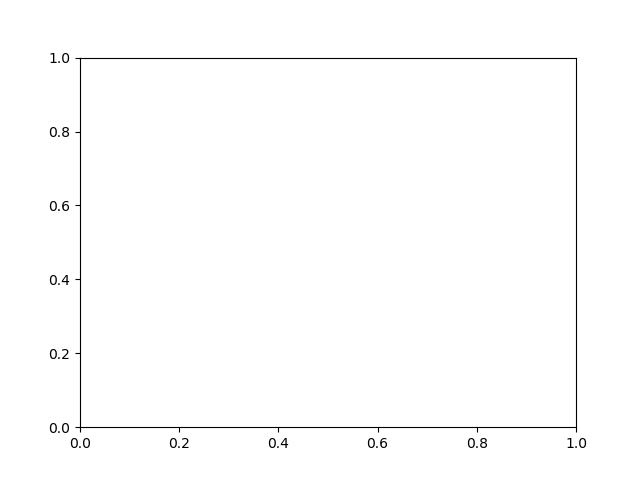

NameError: name 'cmap' is not defined

In [32]:
comp = State_Component(X,labels)

sources
<br>
thanks to react state components idea for handling 
<br>
https://stackoverflow.com/questions/55866439/why-doesnt-mpl-connect-work-when-called-in-the-init-of-a-class
<br>
https://matplotlib.org/users/event_handling.html